<a href="https://colab.research.google.com/github/raphaelp-silva/GNN_Pytorch_geometric/blob/main/GNN_obesity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [283]:
!pip install faiss-cpu
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.3 MB/s eta 0:00:00


# Importando bibliotecas:

In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import torch
import faiss
import networkx as nx

from torch_geometric.data import Data

# Etapa 1 - Carregando os dados:

In [173]:
import kagglehub

# Fazendo o download da ultima versão via api
path = kagglehub.dataset_download("adeniranstephen/obesity-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/adeniranstephen/obesity-prediction-dataset/versions/1


In [174]:
os.listdir(path) #listando os arquivos do diretorio

db = pd.read_csv(os.path.join(path, "ObesityDataSet_raw_and_data_sinthetic.csv"))

# Etapa 2 - Explorando os dados:

In [175]:
db.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [176]:
db_util = db[db['NObeyesdad'] != 'Insufficient_Weight']

In [177]:
db_util.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [178]:
db_util.shape

(1839, 17)

In [179]:
db_util.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1839 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          1839 non-null   object 
 1   Age                             1839 non-null   int64  
 2   Height                          1839 non-null   float64
 3   Weight                          1839 non-null   float64
 4   family_history_with_overweight  1839 non-null   object 
 5   FAVC                            1839 non-null   object 
 6   FCVC                            1839 non-null   float64
 7   NCP                             1839 non-null   float64
 8   CAEC                            1839 non-null   object 
 9   SMOKE                           1839 non-null   object 
 10  CH2O                            1839 non-null   float64
 11  SCC                             1839 non-null   object 
 12  FAF                             1839 no

In [180]:
db_util.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000
mean,24.989668,1.703181,92.011175,2.409897,2.651794,2.028265,0.974850,0.631004
std,6.465982,0.092323,23.529084,0.525574,0.752537,0.612104,0.844166,0.599213
min,14.000000,1.450000,42.300000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,1.630000,75.000000,2.000000,2.635000,1.630000,0.100000,0.000000
50%,23.000000,1.700000,87.660000,2.290000,3.000000,2.000000,1.000000,0.580000
75%,27.000000,1.770000,110.920000,3.000000,3.000000,2.510000,1.550000,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [181]:
db_util['NObeyesdad'].value_counts()

,count
NObeyesdad,
Obesity_Type_I,351
Obesity_Type_III,324
Obesity_Type_II,297
Overweight_Level_I,290
Overweight_Level_II,290
Normal_Weight,287


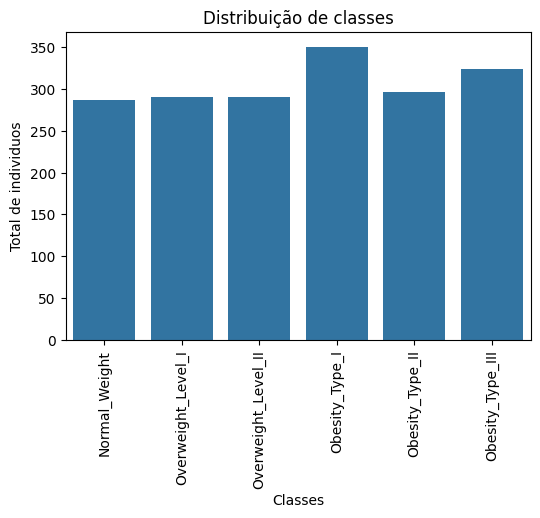

In [182]:
plt.figure(figsize=(6, 4))
sns.countplot(x=db_util['NObeyesdad'])
plt.xticks(rotation=90)
plt.title('Distribuição de classes')
plt.xlabel('Classes')
plt.ylabel('Total de individuos')
plt.show()


# Etapa 3: Verificando valores nulos e visualizando as distribuições e outliers:

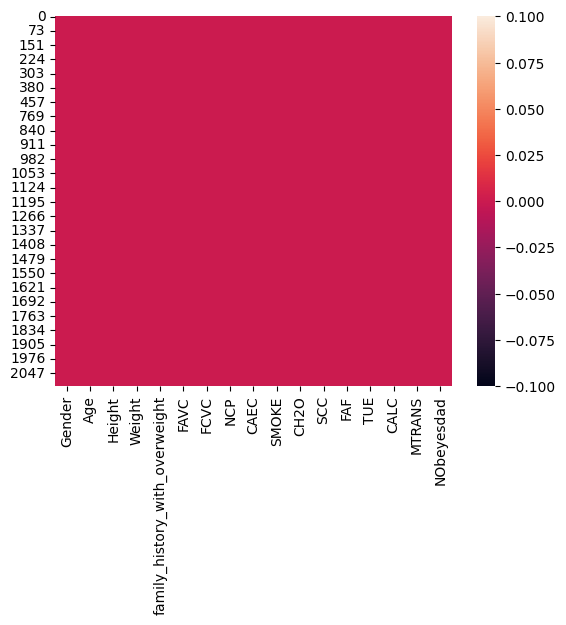

In [183]:
# Verificando valores nulos no dataset:
sns.heatmap(db_util.isnull());

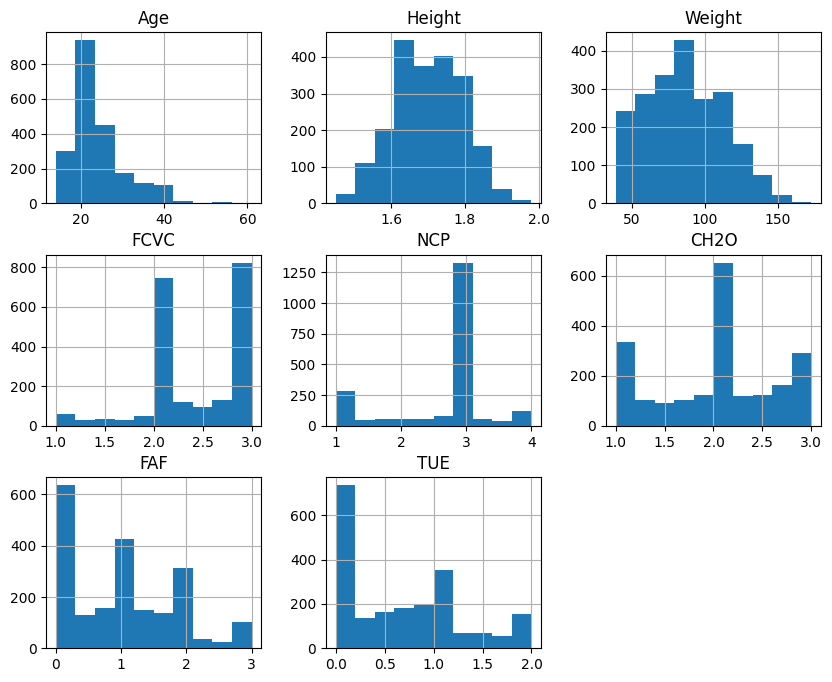

In [184]:
# Visualizado a distribuição de variáveis:

db.hist(figsize=(10,8))
plt.show()

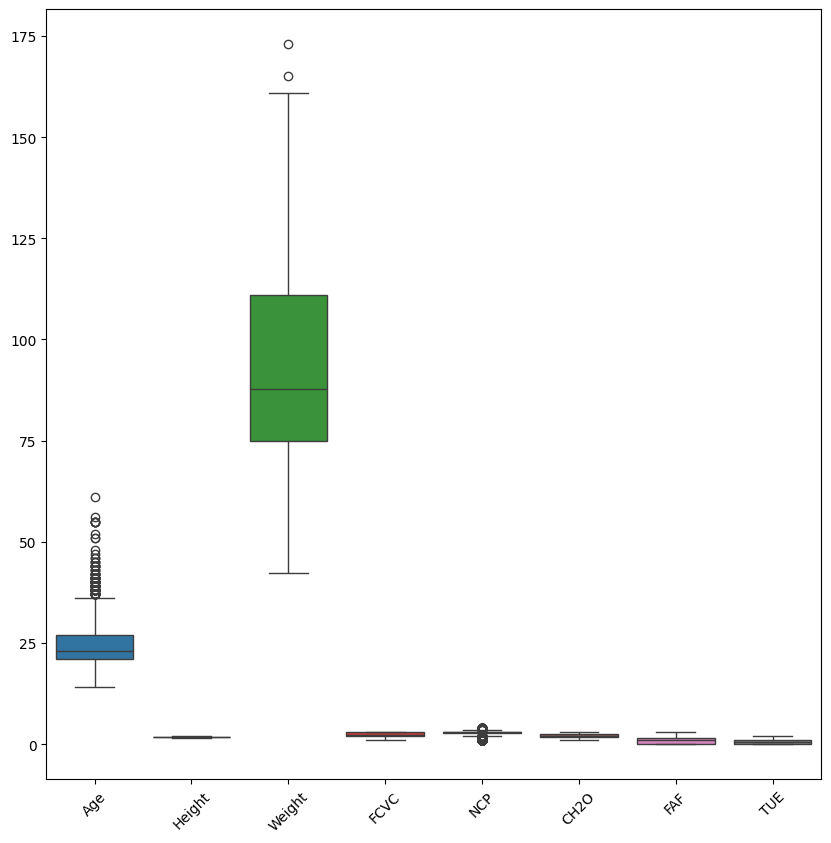

In [185]:
# Visualizando outliers:

plt.figure(figsize=(10, 10))
sns.boxplot(data=db_util.select_dtypes(include=np.number))
plt.xticks(rotation=45)
plt.show()


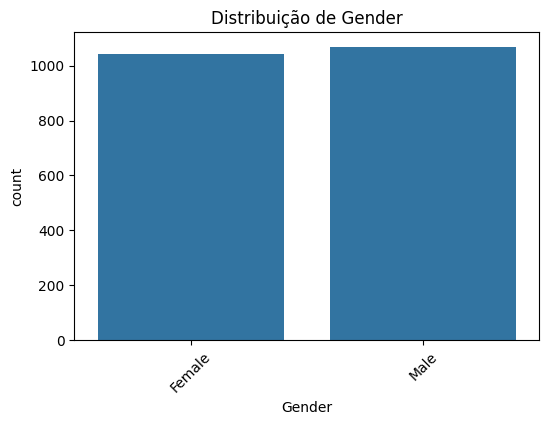

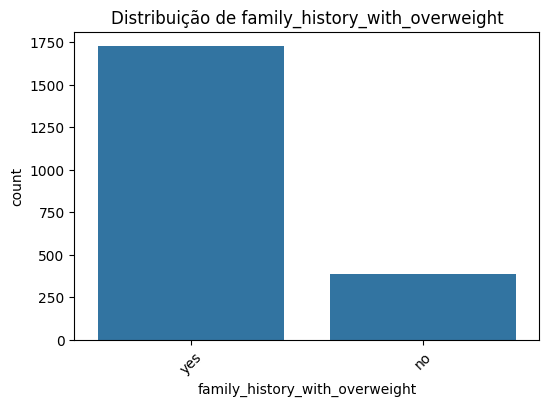

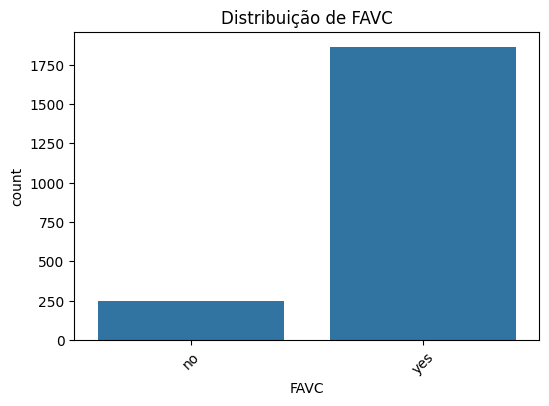

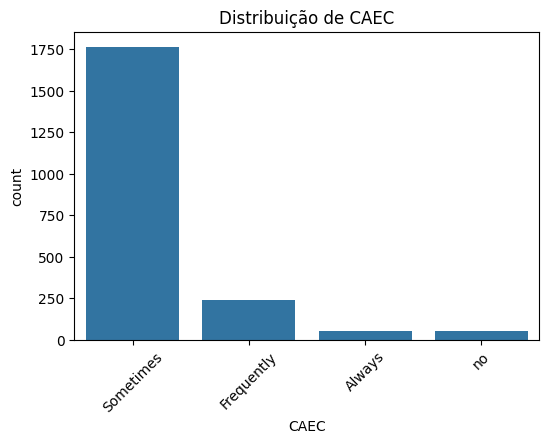

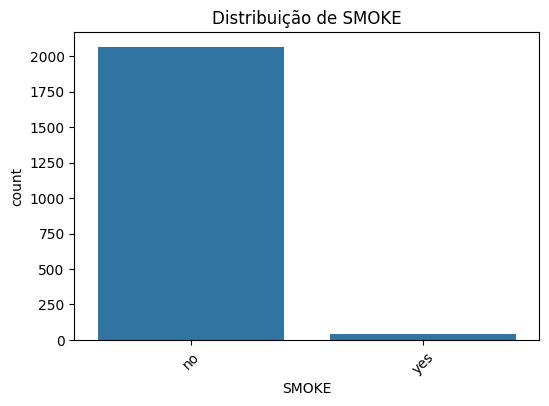

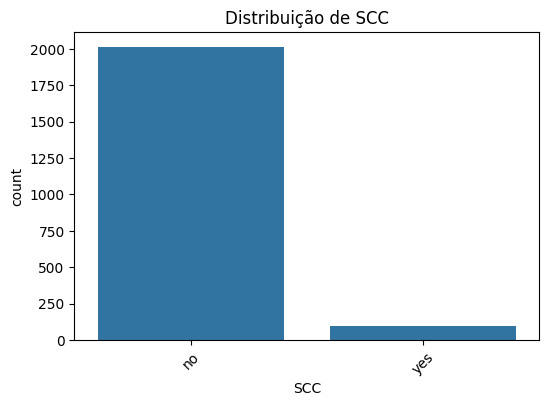

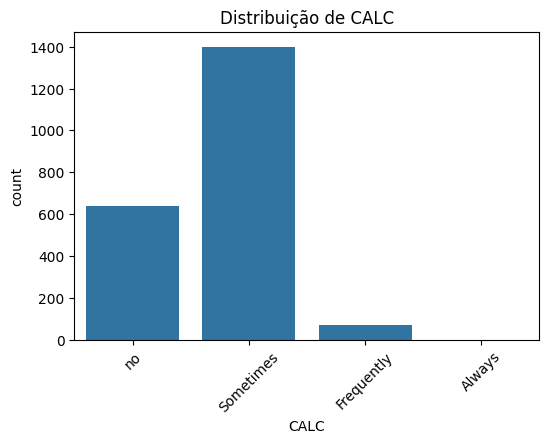

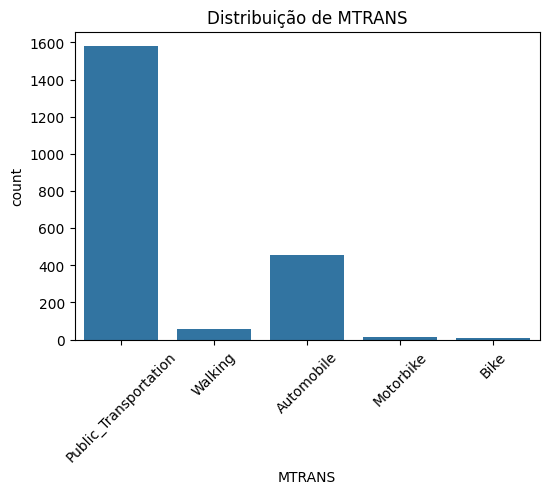

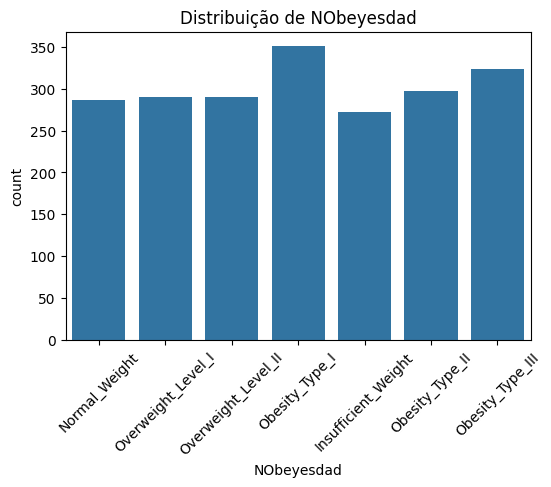

In [186]:
# Contagem de categorias (ex: sexo, nível de atividade física):

for col in db.select_dtypes(include="object").columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=db[col])
    plt.xticks(rotation=45)
    plt.title(f"Distribuição de {col}")
    plt.show()


# Etapa 4: Convertendo variáveis categóricas para numéricas e normalizando as demais variáveis:

In [209]:
# Convertendo colunas (yes/no) para valores binários:

colunas_binarias = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

db_util.loc[:, colunas_binarias] = db[colunas_binarias].apply(lambda x: x.map({'yes': 1, 'no': 0})).astype(int)

# Convertendo coluna 'Gender' para valores binários:

db_util.loc[:, 'Gender'] = db['Gender'].map({'Female': 0, 'Male': 1})

In [210]:
db_util.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21,1.62,64.0,1,0,2.0,3.0,Sometimes,0,2.0,0,0.0,1.0,no,Public_Transportation,Normal_Weight
1,0,21,1.52,56.0,1,0,3.0,3.0,Sometimes,1,3.0,1,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,1,23,1.80,77.0,1,0,2.0,3.0,Sometimes,0,2.0,0,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,1,27,1.80,87.0,0,0,3.0,3.0,Sometimes,0,2.0,0,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,1,22,1.78,89.8,0,0,2.0,1.0,Sometimes,0,2.0,0,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [221]:
# Convertendo valores das colunas de caracteres para valores numéricos:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Lista das colunas categóricas que vamos transformar:
categorical_columns = ['CAEC', 'CALC', 'MTRANS', 'NObeyesdad']

# Criando o OneHotEncoder e aplicando em todas as colunas de uma vez:
onehotencoder = ColumnTransformer(transformers=[("OneHot", OneHotEncoder(), categorical_columns)], remainder='passthrough')

# Transformando os valores:
encoded_data = onehotencoder.fit_transform(db_util)

# retornando os nomes das colunas geradas com o onehotencoder:
transformed_feature_names = onehotencoder.get_feature_names_out()

# criando um novo DataFrame com os valores:
encoded_df = pd.DataFrame(encoded_data, columns=transformed_feature_names).astype('int')

db_encoded = pd.concat([db_util.drop(columns=categorical_columns), encoded_df], axis=1)


In [222]:
db_encoded.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,...,remainder__Weight,remainder__family_history_with_overweight,remainder__FAVC,remainder__FCVC,remainder__NCP,remainder__SMOKE,remainder__CH2O,remainder__SCC,remainder__FAF,remainder__TUE
0,0,21.0,1.62,64.0,1,0,2.0,3.0,0,2.0,...,64.0,1.0,0.0,2.0,3.0,0.0,2.0,0.0,0.0,1.0
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,3.0,...,56.0,1.0,0.0,3.0,3.0,1.0,3.0,1.0,3.0,0.0
2,1,23.0,1.80,77.0,1,0,2.0,3.0,0,2.0,...,77.0,1.0,0.0,2.0,3.0,0.0,2.0,0.0,2.0,1.0
3,1,27.0,1.80,87.0,0,0,3.0,3.0,0,2.0,...,87.0,0.0,0.0,3.0,3.0,0.0,2.0,0.0,2.0,0.0
4,1,22.0,1.78,89.8,0,0,2.0,1.0,0,2.0,...,89.0,0.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0


In [223]:
# Dropando as colunas 'remainder__' que estão duplicadas no db_encoded:

db_encoded = db_encoded.drop(columns=[col for col in db_encoded.columns if 'remainder__' in col])

In [224]:
db_encoded.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,...,OneHot__MTRANS_Bike,OneHot__MTRANS_Motorbike,OneHot__MTRANS_Public_Transportation,OneHot__MTRANS_Walking,OneHot__NObeyesdad_Normal_Weight,OneHot__NObeyesdad_Obesity_Type_I,OneHot__NObeyesdad_Obesity_Type_II,OneHot__NObeyesdad_Obesity_Type_III,OneHot__NObeyesdad_Overweight_Level_I,OneHot__NObeyesdad_Overweight_Level_II
0,0,21.0,1.62,64.0,1,0,2.0,3.0,0,2.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,3.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,23.0,1.80,77.0,1,0,2.0,3.0,0,2.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1,27.0,1.80,87.0,0,0,3.0,3.0,0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,22.0,1.78,89.8,0,0,2.0,1.0,0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Normalizando dados - utilizando o StandardScaler:

In [225]:
from sklearn.preprocessing import StandardScaler

lista_colunas_a_normalizar = ['Age', 'Height', 'Weight', 'CH2O', 'FAF', 'TUE']

# Normalizando os dados:
scaler = StandardScaler()
db_encoded[lista_colunas_a_normalizar] = scaler.fit_transform(db_encoded[lista_colunas_a_normalizar])

In [226]:
db_encoded.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,SMOKE,CH2O,...,OneHot__MTRANS_Bike,OneHot__MTRANS_Motorbike,OneHot__MTRANS_Public_Transportation,OneHot__MTRANS_Walking,OneHot__NObeyesdad_Normal_Weight,OneHot__NObeyesdad_Obesity_Type_I,OneHot__NObeyesdad_Obesity_Type_II,OneHot__NObeyesdad_Obesity_Type_III,OneHot__NObeyesdad_Overweight_Level_I,OneHot__NObeyesdad_Overweight_Level_II
0,0,-0.617192,-0.901229,-1.190815,1,0,2.0,3.0,0,-0.046190,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,-0.617192,-1.984683,-1.530913,1,0,3.0,3.0,1,1.587962,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,-0.307797,1.048989,-0.638157,1,0,2.0,3.0,0,-0.046190,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1,0.310994,1.048989,-0.213036,0,0,3.0,3.0,0,-0.046190,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,-0.462495,0.832298,-0.094002,0,0,2.0,1.0,0,-0.046190,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
db_encoded.info()

## Verificando outliers:

In [235]:
# Verificando se temos outliers nas colunas numéricas ('Age', 'Height', 'Weight', 'CH2O', 'FAF', 'TUE')  usando o método do Intervalo Interquartil (IQR):

Q1 = db_encoded[lista_colunas_a_normalizar].quantile(0.25)
Q3 = db_encoded[lista_colunas_a_normalizar].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = ((db_encoded[lista_colunas_a_normalizar] < limite_inferior) | (db_encoded[lista_colunas_a_normalizar] > limite_superior)).any()
print(f"Existem valores outliers nas colunas? : \n{outliers}")

Existem valores outliers nas colunas? : 
Age        True
Height    False
Weight     True
CH2O      False
FAF       False
TUE       False
dtype: bool


#### OBS: Por hora, vou optar manter os outliers para analisar o comportamento do modelo com essa condição.

# Etapa 5: Analisando correlação entre variáveis:

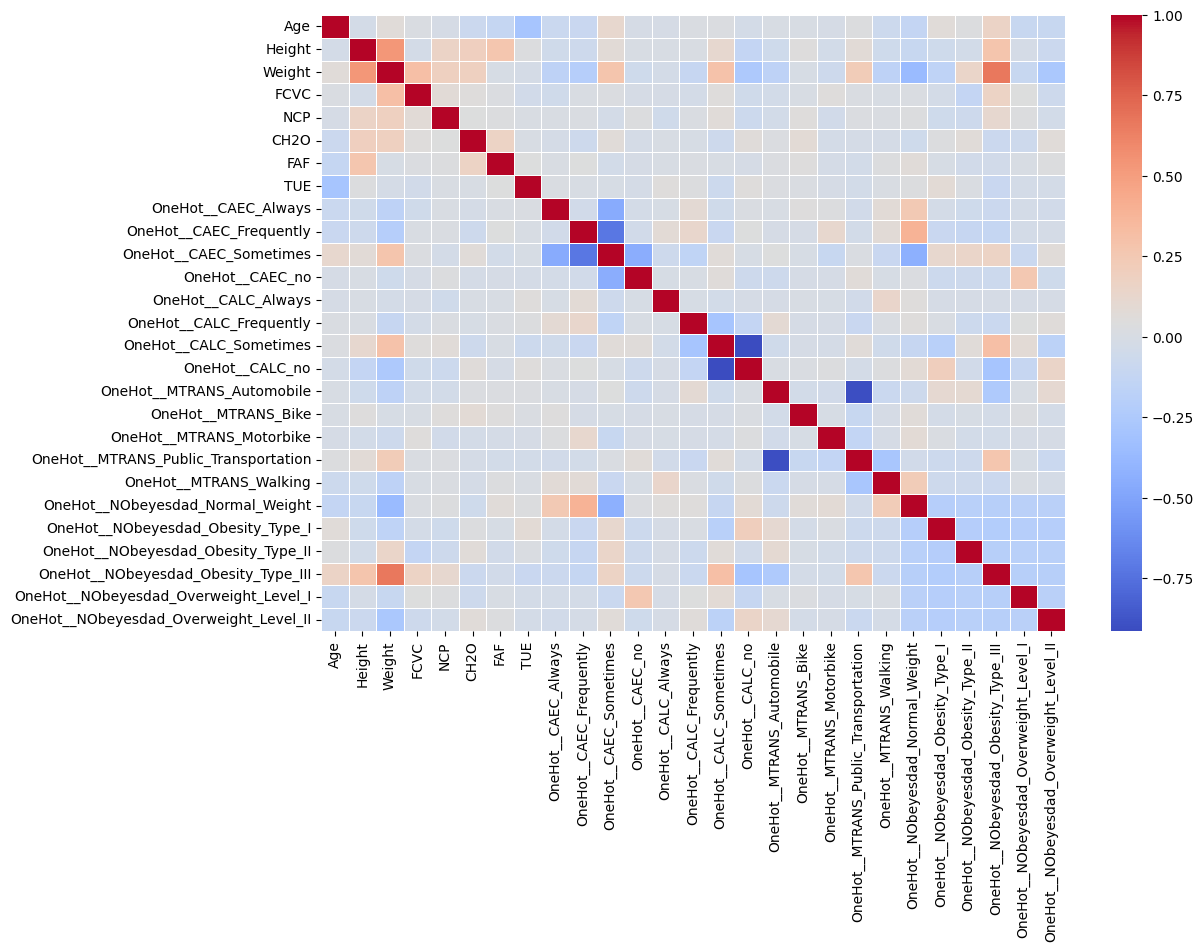

In [241]:
# Matriz de correlação das variáveis:

plt.figure(figsize=(12,8))
correlation_matrix = db_encoded.select_dtypes(include=np.number).corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.show()

# Etapa 6: Gerando representação em grafos (utilizando PyG e FAISS):

In [268]:
# Convertendo todas as colunas para tipo float:
object_columns = db_encoded.select_dtypes(include=['object']).columns #selecionando as colunas com valores do tipo object para inserir na variável

for col in object_columns:
    db_encoded[col] = pd.to_numeric(db_encoded[col], errors='coerce')

In [269]:
features = db_encoded.select_dtypes(include='number').values

In [270]:
# convertendo para tensor pytorch:
X = torch.tensor(features, dtype=torch.float)

In [271]:
print(X.shape)

torch.Size([2111, 32])


In [326]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [327]:
# Criando índice FAISS para distância euclidiana:

index = faiss.IndexFlatL2(X_scaled.shape[1])  # L2 = Distância Euclidiana
index.add(np.array(X_scaled))  # Adicionando dados ao índice

# definindo o número de vizinhos:
k = 20

# Buscando vizinhos mais próximos:
D, I = index.search(np.array(X_scaled), k+1)  #k+1 pois inclui o próprio nó

# Criando listas para PyG:
edge_index = []
for i in range(len(X_scaled)):
    for j in range(1, k+1):  # Pula o primeiro (que é ele mesmo)
        edge_index.append((i, I[i, j]))

# Convertendo para tensor:
edge_index = torch.tensor(edge_index, dtype=torch.long).T

print(edge_index.shape)  # Deve ser (2 (origem -> destino), Nº de arestas)

torch.Size([2, 42220])


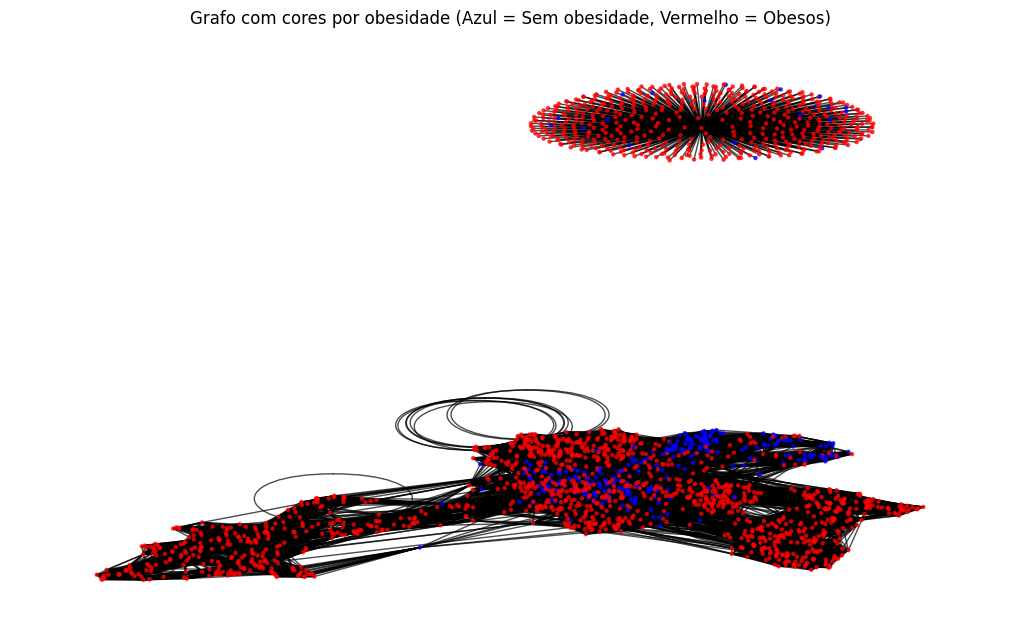

In [334]:
# Criar objeto de grafo do PyG
graph = Data(x=X_scaled, edge_index=edge_index)

# Converter para NetworkX para visualizar
G = nx.Graph()
for i in range(edge_index.shape[1]):
    G.add_edge(edge_index[0, i].item(), edge_index[1, i].item())

color_map = []
for node in G.nodes():  # Iterate through nodes in the graph
    try:
        if db_encoded.iloc[node]['OneHot__NObeyesdad_Normal_Weight'] == 1:
            color_map.append("blue")  # Azul para indivíduos sem obesidade
        else:
            color_map.append("red")  # Vermelho para obesos
    except IndexError:
        color_map.append("gray")  # Assign a default color

# Desenhando o grafo com cores
plt.figure(figsize=(10, 6))
nx.draw(G, node_color=color_map, node_size=5, alpha=0.7)
plt.title("Grafo com cores por obesidade (Azul = Sem obesidade, Vermelho = Obesos)")
plt.show()


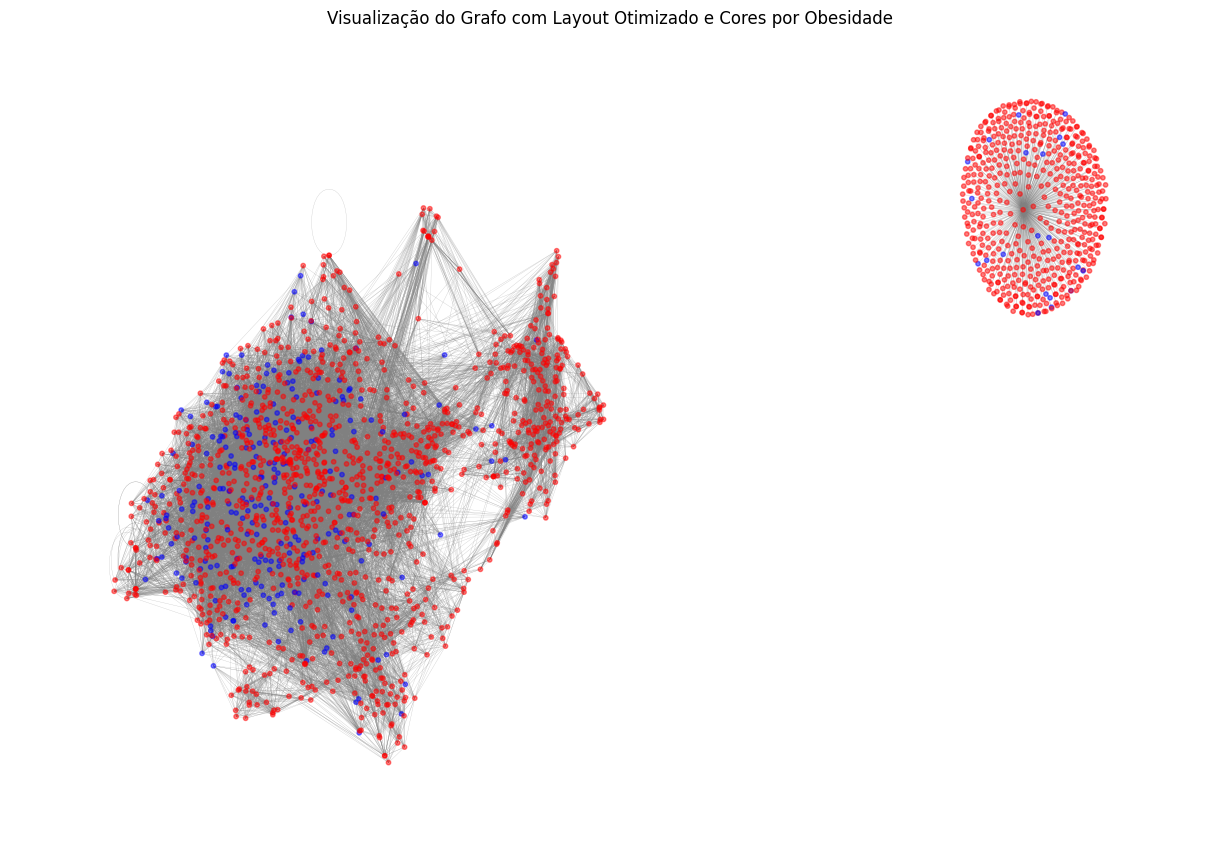

In [335]:
plt.figure(figsize=(12, 8))
nx.draw(G, pos, node_color=color_map, node_size=10, edge_color="gray", alpha=0.5, width=0.2)
plt.title("Visualização do Grafo com Layout Otimizado e Cores por Obesidade")
plt.show()

In [336]:
# Encontrando os componentes (nós) conectados no grafo:

components = list(nx.connected_components(G))

print(f"Número de componentes conectados: {len(components)}")
for i, comp in enumerate(components):
    print(f"Componente {i+1} tem {len(comp)} nós")

Número de componentes conectados: 2
Componente 1 tem 1567 nós
Componente 2 tem 545 nós


In [337]:
# Verificando se temos muitos nós com poucas conexões:

degrees = dict(G.degree())
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1])

print("10 nós com menor grau:")
for node, degree in sorted_degrees[:10]:
    print(f"Nó {node}: {degree} conexões")


10 nós com menor grau:
Nó 1567: 1 conexões
Nó 1568: 1 conexões
Nó 1569: 1 conexões
Nó 1570: 1 conexões
Nó 1571: 1 conexões
Nó 1572: 1 conexões
Nó 1573: 1 conexões
Nó 1574: 1 conexões
Nó 1575: 1 conexões
Nó 1576: 1 conexões


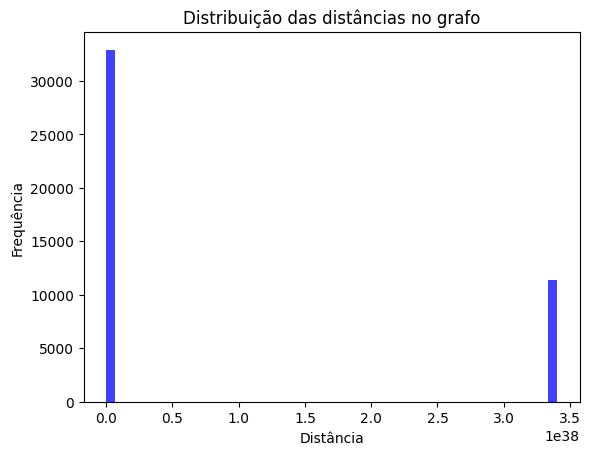

In [338]:
# Calculando a distribuição das distâncias no grafo:

# D contém as distâncias calculadas pelo FAISS
plt.hist(D.flatten(), bins=50, alpha=0.75, color="blue")
plt.xlabel("Distância")
plt.ylabel("Frequência")
plt.title("Distribuição das distâncias no grafo")
plt.show()

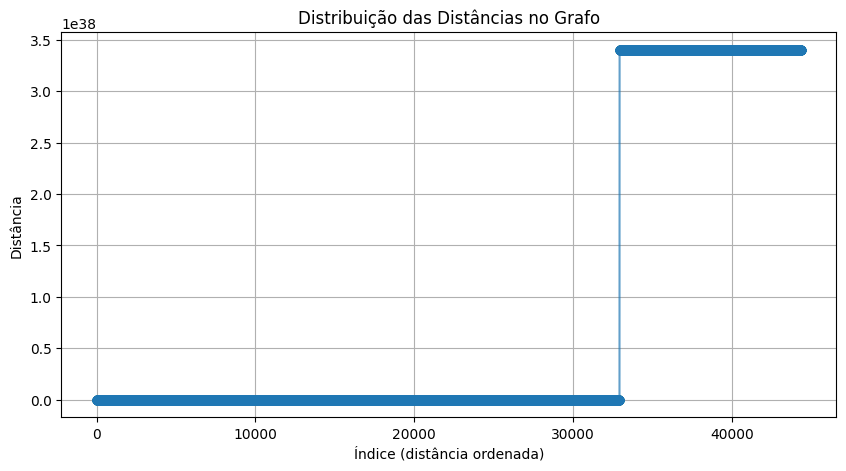

In [339]:
# plotando de outra forma a distribuição das distâncias no grafo:

sorted_distances = np.sort(D.flatten())  # Ordena todas as distâncias
plt.figure(figsize=(10, 5))
plt.plot(sorted_distances, marker="o", linestyle="-", alpha=0.7)
plt.xlabel("Índice (distância ordenada)")
plt.ylabel("Distância")
plt.title("Distribuição das Distâncias no Grafo")
plt.grid(True)
plt.show()

# Aqui encontramos o ponto onde os nós se separam dando origem a 2 clusters no grafo

In [293]:
# Salvar e baixar para rodar no computador o grafo:

#!pip install pyvis
#from pyvis.network import Network
#from google.colab import files

#net = Network(notebook=True,  cdn_resources='in_line')
#net.from_nx(G)
#net.save_graph("graph.html")
#files.download("graph.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>